In [1]:
# Orbit comparisons
from galpy.orbit import Orbit
from galpy import potential
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation
from IPython.display import HTML
from galpy.potential import MWPotential2014,ChandrasekharDynamicalFrictionForce,HernquistPotential,MovingObjectPotential
from galpy.util import conversion
from streamtools.df import streamspraydf

from stream_package.stream_package import graphics

from galpy.potential import MWPotential

/home/student04/.local/lib/python3.10/site-packages/galpy/util/bovy_conversion.py:6: FutureWarning: galpy.util.bovy_conversion is being deprecated in favor of galpy.util.conversion; all functions in there are the same; please switch to the new import, because the old import will be removed in v1.9
  warnings.warn('galpy.util.bovy_conversion is being deprecated in favor of galpy.util.conversion; all functions in there are the same; please switch to the new import, because the old import will be removed in v1.9',FutureWarning)

/home/student04/.local/lib/python3.10/site-packages/galpy/util/bovy_coords.py:6: FutureWarning: galpy.util.bovy_coords is being deprecated in favor of galpy.util.coords; all functions in there are the same; please switch to the new import, because the old import will be removed in v1.9
  warnings.warn('galpy.util.bovy_coords is being deprecated in favor of galpy.util.coords; all functions in there are the same; please switch to the new import, because the old impo

## Initialisation

In [21]:
#Galpy internal units scaling factors
ro = 8. #distance to Galactic centre in kpc, scales distances
vo = 220. #circular velocity at solar circle
to=conversion.time_in_Gyr(ro=ro,vo=vo)
mo=conversion.mass_in_msol(ro=ro,vo=vo)

gcname='Bootes III'
mass=1.82E7 * 5

#External potential
pot1 = MWPotential2014.copy()
pot2 = MWPotential2014.copy()
pot2[2]*= 2

# Orbit made from pace data
sixD_pace = [209.3, 26.8, 46.5, -1.176, -0.89, 197.5]
o_p = Orbit(vxvv = sixD_pace, ro=ro, vo=vo, solarmotion = [-11.1, 24.0, 7.25], radec=True)
o_p.turn_physical_off()

# Orbit made from SIMBAD data
o_s = Orbit.from_name(gcname, ro=ro, vo=vo, solarmotion = [-11.1, 24.0, 7.25])
o_s.turn_physical_off()

## Experimenting, adding LMC to potential?

In [3]:
mass_lmc=1.0e11 #solar masses
rscale_lmc=10.2 #kpc

tdisrupt=5

#Initialize and integrate the orbit of the LMC
#Note orbit has to be integrated back 5 Gyr
#Note we assume the LMC experienced dynamical friction due to MW
o_lmc = Orbit.from_name('LMC', ro=ro, vo=vo, solarmotion=[-11.1, 24.0, 7.25])
ts= np.linspace(0.,-tdisrupt/to,1001)
cdf= ChandrasekharDynamicalFrictionForce(GMs=mass_lmc/mo, rhm=rscale_lmc/ro, dens=pot1, ro=ro,vo=vo)
o_lmc.integrate(ts,pot1+cdf)

#Setup a moving Hernquist potential to represent the LMC
pot1_lmc = HernquistPotential(mass_lmc/mo,rscale_lmc/ro,ro=ro,vo=vo)
moving_pot1_lmc = MovingObjectPotential(o_lmc, pot1_lmc,ro=ro,vo=vo)

#Add the moving Hernquest potential to the MW
total_pot1 = [pot1]
total_pot1 += [moving_pot1_lmc]

In [4]:
tdisrupt=2.5

o_lmc = Orbit.from_name('LMC', ro=ro, vo=vo, solarmotion=[-11.1, 24.0, 7.25])
ts= np.linspace(0.,-tdisrupt/to,1001)
cdf= ChandrasekharDynamicalFrictionForce(GMs=mass_lmc/mo, rhm=rscale_lmc/ro, dens=pot2, ro=ro,vo=vo)
o_lmc.integrate(ts,pot2+cdf)

#Setup a moving Hernquist potential to represent the LMC
pot2_lmc = HernquistPotential(mass_lmc/mo,rscale_lmc/ro,ro=ro,vo=vo)
moving_pot2_lmc = MovingObjectPotential(o_lmc, pot2_lmc,ro=ro,vo=vo)

#Add the moving Hernquest potential to the MW
total_pot2 = [pot2]
total_pot2 += [moving_pot2_lmc]

Pericentre is at 6.255678526225947 kpc
Apocentre is at 207.6029541305758 kpc


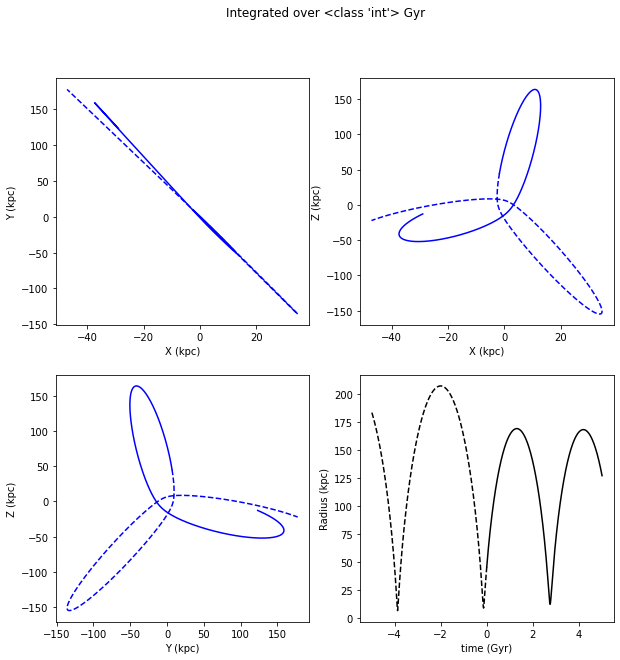

In [16]:
fig1 = graphics.orbit_plots(o_p, total_pot1, tint=5)

## Now add MW centre baryonic acceleration

In [18]:
>>> from galpy.potential import (evaluateRforces, evaluatephitorques,
                                 evaluatezforces)
>>> loc_origin= 1e-4 # Small offset in R to avoid numerical issues
>>> ax= lambda t: evaluateRforces(moving_pot1_lmc,loc_origin,0.,phi=0.,t=t,
                                  use_physical=False)
>>> ay= lambda t: evaluatephitorques(moving_pot1_lmc,loc_origin,0.,phi=0.,t=t,
                                    use_physical=False)/loc_origin
>>> az= lambda t: evaluatezforces(moving_pot1_lmc,loc_origin,0.,phi=0.,t=t,
                                  use_physical=False)

>>> t_intunits= o_lmc.time(use_physical=False)[::-1] # need to reverse the order for interp
>>> ax4int= np.array([ax(t) for t in t_intunits])
>>> ax_int= lambda t: np.interp(t,t_intunits,ax4int)
>>> ay4int= np.array([ay(t) for t in t_intunits])
>>> ay_int= lambda t: np.interp(t,t_intunits,ay4int)
>>> az4int= np.array([az(t) for t in t_intunits])
>>> az_int= lambda t: np.interp(t,t_intunits,az4int)

>>> from galpy.potential import NonInertialFrameForce
>>> nip= NonInertialFrameForce(a0=[ax_int,ay_int,az_int])

Pericentre is at 8.768350412499318 kpc
Apocentre is at 167.82598691991075 kpc


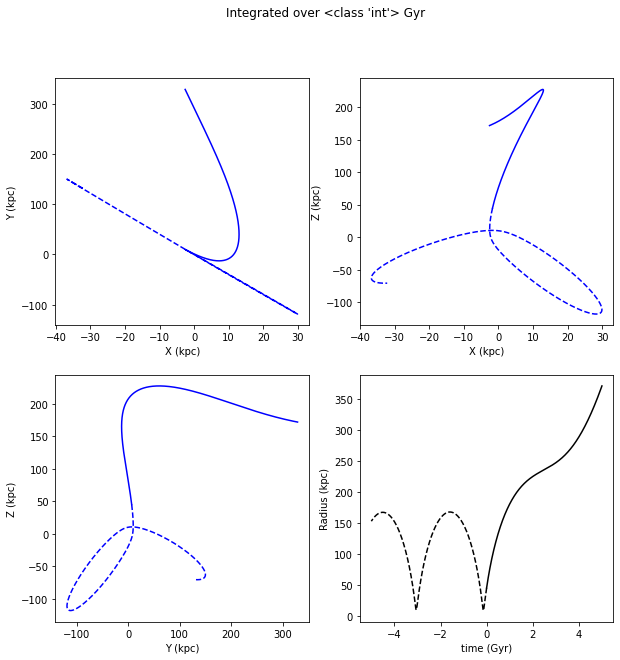

In [27]:
fig1 = graphics.orbit_plots(o_p, pot=pot1 + moving_pot1_lmc + nip , tint=5)

Pericentre is at 4.246133778883195 kpc
Apocentre is at 93.95993010012295 kpc


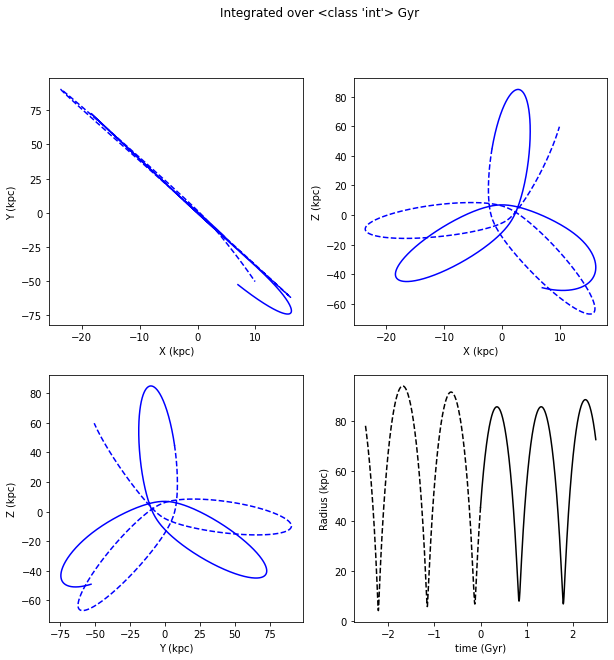

In [30]:
fig1 = graphics.orbit_plots(o_p, total_pot2, tint=2.5)

In [28]:
>>> from galpy.potential import (evaluateRforces, evaluatephitorques,
                                 evaluatezforces)
>>> loc_origin= 1e-4 # Small offset in R to avoid numerical issues
>>> ax= lambda t: evaluateRforces(moving_pot2_lmc,loc_origin,0.,phi=0.,t=t,
                                  use_physical=False)
>>> ay= lambda t: evaluatephitorques(moving_pot2_lmc,loc_origin,0.,phi=0.,t=t,
                                    use_physical=False)/loc_origin
>>> az= lambda t: evaluatezforces(moving_pot2_lmc,loc_origin,0.,phi=0.,t=t,
                                  use_physical=False)

>>> t_intunits= o_lmc.time(use_physical=False)[::-1] # need to reverse the order for interp
>>> ax4int= np.array([ax(t) for t in t_intunits])
>>> ax_int= lambda t: np.interp(t,t_intunits,ax4int)
>>> ay4int= np.array([ay(t) for t in t_intunits])
>>> ay_int= lambda t: np.interp(t,t_intunits,ay4int)
>>> az4int= np.array([az(t) for t in t_intunits])
>>> az_int= lambda t: np.interp(t,t_intunits,az4int)

>>> from galpy.potential import NonInertialFrameForce
>>> nip= NonInertialFrameForce(a0=[ax_int,ay_int,az_int])

Pericentre is at 7.087378487183822 kpc
Apocentre is at 84.1511168077662 kpc


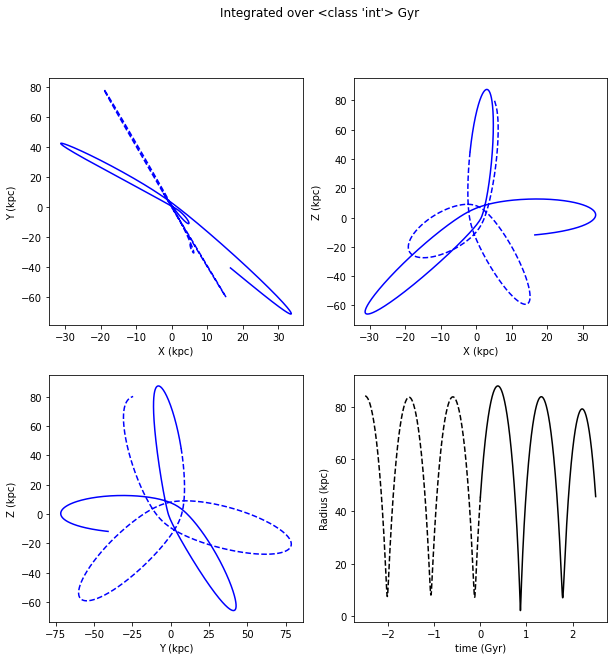

In [29]:
fig1 = graphics.orbit_plots(o_p, pot=pot2 + moving_pot2_lmc + nip , tint=2.5)

## Orbit modeling

In [9]:
# Integrate orbit of Boo3
tint = 5 # Integration time
delt = np.linspace(0,-tint/to,1000)
deltfwd = np.linspace(0, tint/to, 1000)

tint2 = 2.5
delt2 = np.linspace(0,-tint2/to,1000)
delt2fwd = np.linspace(0, tint2/to, 1000)


oint_p1 = o_p()
oint_p1.integrate(delt, pot=pot1)
ointfwd_p1 = o_p()
ointfwd_p1.integrate(deltfwd, pot=pot1)

oint_p2 = o_p()
oint_p2.integrate(delt, pot=pot2)
ointfwd_p2 = o_p()
ointfwd_p2.integrate(deltfwd, pot=pot2)

oint_s1 = o_s()
oint_s1.integrate(delt, pot=pot1)
ointfwd_s1 = o_s()
ointfwd_s1.integrate(deltfwd, pot=pot1)

oint_s2 = o_s()
oint_s2.integrate(delt, pot=pot2)
ointfwd_s2 = o_s()
ointfwd_s2.integrate(deltfwd, pot=pot2)

## Orbit for Pace data:
### MWPotential2014

Pericentre is at 8.58855652048451 kpc
Apocentre is at 181.0337864253273 kpc


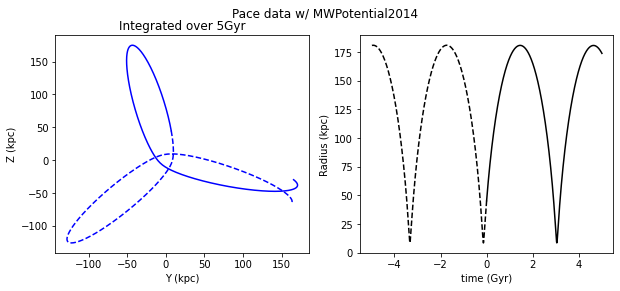

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('Pace data w/ MWPotential2014')

# Orbit in Y-Z
ax1.plot(oint_p1.y(delt)*ro, oint_p1.z(delt)*ro, "b--")
ax1.plot(ointfwd_p1.y(deltfwd)*ro, ointfwd_p1.z(deltfwd)*ro, "b-")
ax1.set_xlabel('Y (kpc)')
ax1.set_ylabel('Z (kpc)')
ax1.set_title('Integrated over 5Gyr')

# Orbit radius vs. time
ax2.plot(delt*to, oint_p1.r(delt)*ro, "k--")
ax2.plot(deltfwd*to, ointfwd_p1.r(deltfwd)*ro, "k-")
ax2.set_xlabel('time (Gyr)')
ax2.set_ylabel('Radius (kpc)')

print('Pericentre is at', min(oint_p1.r(delt)*ro), 'kpc')
print('Apocentre is at', max(oint_p1.r(delt)*ro), 'kpc')

### MWPotential2014 with double mass

Pericentre is at 6.932122216119428 kpc
Apocentre is at 86.73492781501623 kpc


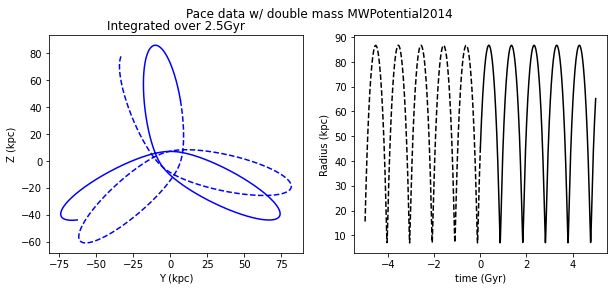

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('Pace data w/ double mass MWPotential2014')


# Orbit in Y-Z
ax1.plot(oint_p2.y(delt2)*ro, oint_p2.z(delt2)*ro, "b--")
ax1.plot(ointfwd_p2.y(delt2fwd)*ro, ointfwd_p2.z(delt2fwd)*ro, "b-")
ax1.set_xlabel('Y (kpc)')
ax1.set_ylabel('Z (kpc)')
ax1.set_title('Integrated over 2.5Gyr')

# Orbit radius vs. time
ax2.plot(delt*to, oint_p2.r(delt)*ro, "k--")
ax2.plot(deltfwd*to, ointfwd_p2.r(deltfwd)*ro, "k-")
ax2.set_xlabel('time (Gyr)')
ax2.set_ylabel('Radius (kpc)')

print('Pericentre is at', min(oint_p2.r(delt)*ro), 'kpc')
print('Apocentre is at', max(oint_p2.r(delt)*ro), 'kpc')

## Orbit for SIMBAD data:
### MWPotential2014

Pericentre is at 14.283197910790449 kpc
Apocentre is at 258.4699778406865 kpc


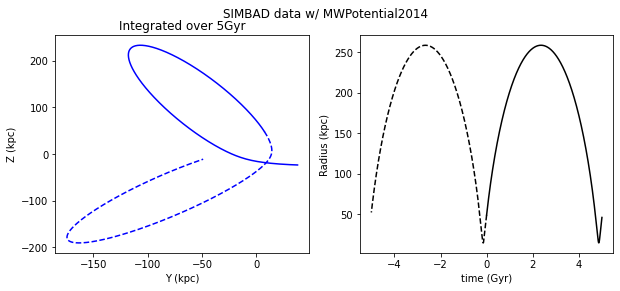

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('SIMBAD data w/ MWPotential2014')

# Orbit in Y-Z
ax1.plot(oint_s1.y(delt)*ro, oint_s1.z(delt)*ro, "b--")
ax1.plot(ointfwd_s1.y(deltfwd)*ro, ointfwd_s1.z(deltfwd)*ro, "b-")
ax1.set_xlabel('Y (kpc)')
ax1.set_ylabel('Z (kpc)')
ax1.set_title('Integrated over 5Gyr')

# Orbit radius vs. time
ax2.plot(delt*to, oint_s1.r(delt)*ro, "k--")
ax2.plot(deltfwd*to, ointfwd_s1.r(deltfwd)*ro, "k-")
ax2.set_xlabel('time (Gyr)')
ax2.set_ylabel('Radius (kpc)')

print('Pericentre is at', min(oint_s1.r(delt)*ro), 'kpc')
print('Apocentre is at', max(oint_s1.r(delt)*ro), 'kpc')

### MWPotential2014 with double mass

Pericentre is at 11.556034331076232 kpc
Apocentre is at 101.14285447943482 kpc


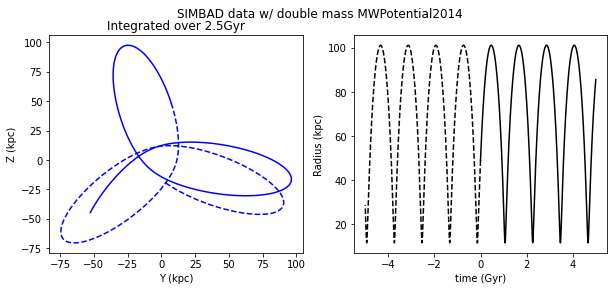

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('SIMBAD data w/ double mass MWPotential2014')

# Orbit in Y-Z
ax1.plot(oint_s2.y(delt2)*ro, oint_s2.z(delt2)*ro, "b--")
ax1.plot(ointfwd_s2.y(delt2fwd)*ro, ointfwd_s2.z(delt2fwd)*ro, "b-")
ax1.set_xlabel('Y (kpc)')
ax1.set_ylabel('Z (kpc)')
ax1.set_title('Integrated over 2.5Gyr')

# Orbit radius vs. time
ax2.plot(delt*to, oint_s2.r(delt)*ro, "k--")
ax2.plot(deltfwd*to, ointfwd_s2.r(deltfwd)*ro, "k-")
ax2.set_xlabel('time (Gyr)')
ax2.set_ylabel('Radius (kpc)')

print('Pericentre is at', min(oint_s2.r(delt)*ro), 'kpc')
print('Apocentre is at', max(oint_s2.r(delt)*ro), 'kpc')